Attribute Information
1. **date**: year-month-day hour:minute:second
2. **Appliances**: energy use in Wh (watt-hour)
3. **lights**: energy use of light fixtures in the house in Wh (watt-hour)
4. **T1**: Temperature in kitchen area, in Celsius
5. **RH_1**: Humidity in kitchen area, in %
6. **T2**: Temperature in living room area, in Celsius
7. **RH_2**: Humidity in living room area, in %
8. **T3**: Temperature in laundry room area
9. **RH_3**: Humidity in laundry room area, in %
10. **T4**: Temperature in office room, in Celsius
11. **RH_4**: Humidity in office room, in %
12. **T5**: Temperature in bathroom, in Celsius
13. **RH_5**: Humidity in bathroom, in %
14. **T6**: Temperature outside the building (north side), in Celsius
15. **RH_6**: Humidity outside the building (north side), in %
16. **T7**: Temperature in ironing room , in Celsius
17. **RH_7**: Humidity in ironing room, in %
18. **T8**: Temperature in teenager room 2, in Celsius
19. **RH_8**: Humidity in teenager room 2, in %
20. **T9**: Temperature in parents room, in Celsius
21. **RH_9**: Humidity in parents room, in %
22. **To**: Temperature outside (from Chievres weather station), in Celsius
23. **Pressure**: (from Chievres weather station), in mm Hg
24. **RH_out**: Humidity outside (from Chievres weather station), in %
25. **Wind speed**: (from Chievres weather station), in m/s
26. **Visibility**: (from Chievres weather station), in km
27. **Tdewpoint**: (from Chievres weather station), Ã‚Â°C
28. **rv1**: Random variable 1, nondimensional
29. **rv2**: Random variable 2, nondimensional

In [2]:
# required library imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn import decomposition
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

# Recover default matplotlib settings
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
#sns.set(rc={"axes.facecolor":"#283747", "axes.grid":False,'xtick.labelsize':10,'ytick.labelsize':10})

### Reading Raw Data

In [3]:
# define relative data path (according the current path of this notebook)

df = pd.read_csv('energydata_complete.csv')
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [4]:
df.tail()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
19730,2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
19731,2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
19732,2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
19733,2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
19734,2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


In [5]:
df.shape

(19735, 29)

In [6]:
df['date'] = pd.to_datetime(df['date'])

In [7]:
#Number of null values in all columns
df.isnull().sum().sort_values()

date           0
Tdewpoint      0
Visibility     0
Windspeed      0
RH_out         0
Press_mm_hg    0
T_out          0
RH_9           0
T9             0
RH_8           0
T8             0
RH_7           0
T7             0
rv1            0
RH_6           0
RH_5           0
T5             0
RH_4           0
T4             0
RH_3           0
T3             0
RH_2           0
T2             0
RH_1           0
T1             0
lights         0
Appliances     0
T6             0
rv2            0
dtype: int64

In [42]:
from sklearn.model_selection import train_test_split

# 75% of the data is usedfor the training of the models and the rest is used for testing
train, test = train_test_split(df,test_size=0.2,random_state=42)

In [43]:
# Divide the columns based on type for clear column management 

col_temp = ["T1","T2","T3","T4","T5","T6","T7","T8","T9"]

col_hum = ["RH_1","RH_2","RH_3","RH_4","RH_5","RH_6","RH_7","RH_8","RH_9"]

col_weather = ["T_out", "Tdewpoint","RH_out","Press_mm_hg",
                "Windspeed","Visibility"] 
col_light = ["lights"]

col_randoms = ["rv1", "rv2"]

col_target = ["Appliances"]

In [44]:
# Seperate dependent and independent variables 
feature_vars = train[col_temp + col_hum + col_weather + col_light + col_randoms ]
target_vars = train[col_target]

In [45]:
feature_vars.describe()

,T1,T2,T3,T4,T5,T6,T7,T8,T9,RH_1,...,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Visibility,lights,rv1,rv2
count,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,...,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000,15788.000000
mean,21.688684,20.345215,22.269113,20.854106,19.598492,7.913931,20.266936,22.029474,19.488493,40.266486,...,41.570982,7.418384,3.781387,79.822742,755.532075,4.030780,38.330689,3.808589,25.027694,25.027694
std,1.609561,2.196357,2.007629,2.051129,1.850812,6.102256,2.116903,1.959194,2.021992,3.957219,...,4.156227,5.327514,4.202189,14.895451,7.373040,2.436011,11.815744,7.963182,14.504991,14.504991
min,16.790000,16.100000,17.200000,15.100000,15.330000,-6.030000,15.390000,16.306667,14.890000,27.023333,...,29.166667,-5.000000,-6.600000,24.000000,729.300000,0.000000,1.000000,0.000000,0.006033,0.006033
25%,20.775937,18.823333,20.790000,19.533333,18.290000,3.595000,18.700000,20.790000,18.000000,37.399167,...,38.530000,3.633333,0.933333,70.333333,750.916667,2.000000,29.000000,0.000000,12.510037,12.510037
50%,21.600000,20.000000,22.100000,20.633333,19.390000,7.300000,20.060000,22.100000,19.390000,39.663333,...,40.933333,6.933333,3.433333,84.000000,756.100000,3.666667,40.000000,0.000000,24.912220,24.912220
75%,22.600000,21.500000,23.290000,22.100000,20.632083,11.263333,21.600000,23.390000,20.600000,43.060000,...,44.363333,10.416667,6.600000,91.666667,760.937500,5.500000,40.000000,0.000000,37.665543,37.665543
max,26.260000,29.856667,29.236000,26.200000,25.795000,28.290000,25.963333,27.230000,24.500000,57.423333,...,53.326667,26.100000,15.400000,100.000000,772.300000,14.000000,66.000000,70.000000,49.996530,49.996530


In [46]:
feature_vars.lights.value_counts() / len(feature_vars) *100

0     77.305549
10    11.185711
20     8.164429
30     2.881936
40     0.405371
50     0.044337
60     0.006334
70     0.006334
Name: lights, dtype: float64

**Alot of zeros in light column with 77% of data**

In [47]:
# droip light column
feature_vars.drop(['lights'], axis=1 , inplace= True)

In [48]:
# plotly
from chart_studio import plotly
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# To understand the timeseries variation of the applaince energy consumption
visData = go.Scatter( x= df.date  ,  mode = "lines", y = df.Appliances )
layout = go.Layout(title = 'Appliance energy consumption measurement' , xaxis=dict(title='Date'), yaxis=dict(title='(Wh)'))
fig = go.Figure(data=[visData],layout=layout)

iplot(fig)

In [49]:
((pd.to_datetime(df['date']).dt.dayofweek)// 5 == 1).astype(float)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
19730    0.0
19731    0.0
19732    0.0
19733    0.0
19734    0.0
Name: date, Length: 19735, dtype: float64

In [50]:
# Adding column to mark weekdays (0) and weekends(1) for time series evaluation , 
df['WEEKDAY'] = ((pd.to_datetime(df['date']).dt.dayofweek)// 5 == 1).astype(float)
# There are 5472 weekend recordings 
df['WEEKDAY'].value_counts()

0.0    14263
1.0     5472
Name: WEEKDAY, dtype: int64

In [51]:
# Find rows with weekday 
temp_weekday =  df[df['WEEKDAY'] == 0]
# To understand the timeseries variation of the applaince energy consumption
visData = go.Scatter( x= temp_weekday.date  ,  mode = "lines", y = temp_weekday.Appliances )
layout = go.Layout(title = 'Appliance energy consumption measurement without weekdays' , xaxis=dict(title='Date'), yaxis=dict(title='(Wh)'))
fig = go.Figure(data=[visData],layout=layout)

iplot(fig)

In [52]:
# Find rows with weekday 
temp_weekday =  df[df['WEEKDAY'] == 1]
# To understand the timeseries variation of the applaince energy consumption
visData = go.Scatter( x= temp_weekday.date  ,  mode = "lines", y = temp_weekday.Appliances )
layout = go.Layout(title = 'Appliance energy consumption measurement on weekdays' , xaxis=dict(title='Date'), yaxis=dict(title='(Wh)'))
fig = go.Figure(data=[visData],layout=layout)

iplot(fig)

In [53]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour

In [54]:
jan_0 = df[df['WEEKDAY'] == 0][df['month']== 1]

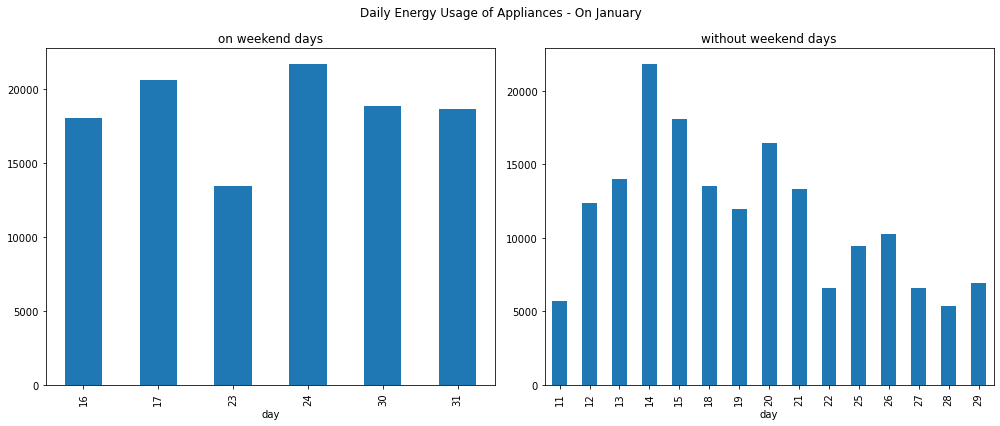

In [55]:
jan = df[df['month']== 1]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax = ax.flatten()

x = ['on weekend days','without weekend days']
for i in range(0, 2):
    jan.query(f"WEEKDAY == {i}")[['day', 'Appliances']].groupby('day')['Appliances'].sum().plot.bar(ax=ax[i-1], title=x[i-1])

plt.suptitle('Daily Energy Usage of Appliances - On January')
plt.tight_layout()
plt.show()

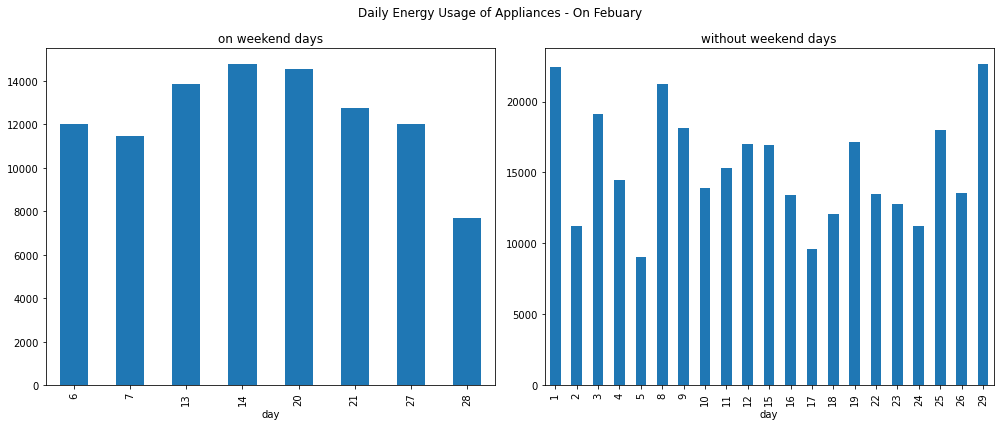

In [56]:
feb = df[df['month']== 2]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax = ax.flatten()

x = ['on weekend days','without weekend days']
for i in range(0, 2):
    feb.query(f"WEEKDAY == {i}")[['day', 'Appliances']].groupby('day')['Appliances'].sum().plot.bar(ax=ax[i-1], title=x[i-1])

plt.suptitle('Daily Energy Usage of Appliances - On Febuary')
plt.tight_layout()
plt.show()

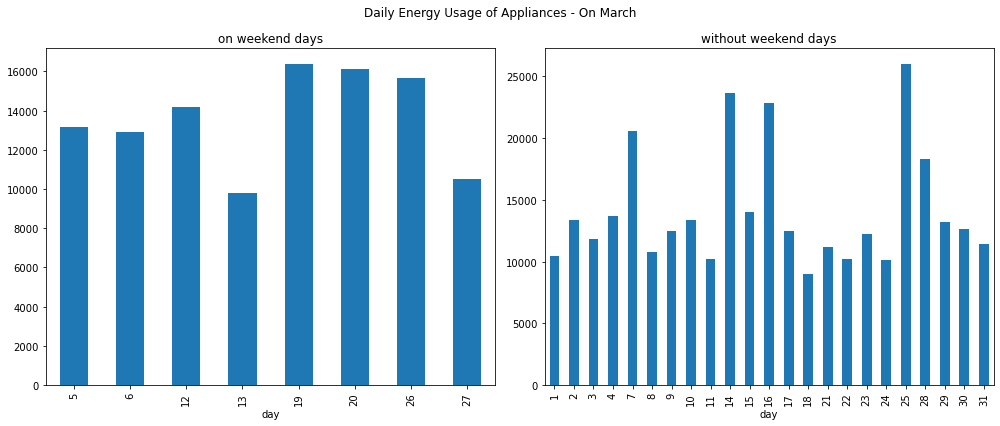

In [57]:
mar = df[df['month']== 3]

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax = ax.flatten()

x = ['on weekend days','without weekend days']
for i in range(0, 2):
    mar.query(f"WEEKDAY == {i}")[['day', 'Appliances']].groupby('day')['Appliances'].sum().plot.bar(ax=ax[i-1], title=x[i-1])

plt.suptitle('Daily Energy Usage of Appliances - On March')
plt.tight_layout()
plt.show()

array([[<AxesSubplot:title={'center':'T1'}>,
        <AxesSubplot:title={'center':'T2'}>,
        <AxesSubplot:title={'center':'T3'}>,
        <AxesSubplot:title={'center':'T4'}>,
        <AxesSubplot:title={'center':'T5'}>],
       [<AxesSubplot:title={'center':'T6'}>,
        <AxesSubplot:title={'center':'T7'}>,
        <AxesSubplot:title={'center':'T8'}>,
        <AxesSubplot:title={'center':'T9'}>,
        <AxesSubplot:title={'center':'RH_1'}>],
       [<AxesSubplot:title={'center':'RH_2'}>,
        <AxesSubplot:title={'center':'RH_3'}>,
        <AxesSubplot:title={'center':'RH_4'}>,
        <AxesSubplot:title={'center':'RH_5'}>,
        <AxesSubplot:title={'center':'RH_6'}>],
       [<AxesSubplot:title={'center':'RH_7'}>,
        <AxesSubplot:title={'center':'RH_8'}>,
        <AxesSubplot:title={'center':'RH_9'}>,
        <AxesSubplot:title={'center':'T_out'}>,
        <AxesSubplot:title={'center':'Tdewpoint'}>],
       [<AxesSubplot:title={'center':'RH_out'}>,
        <AxesSubplo

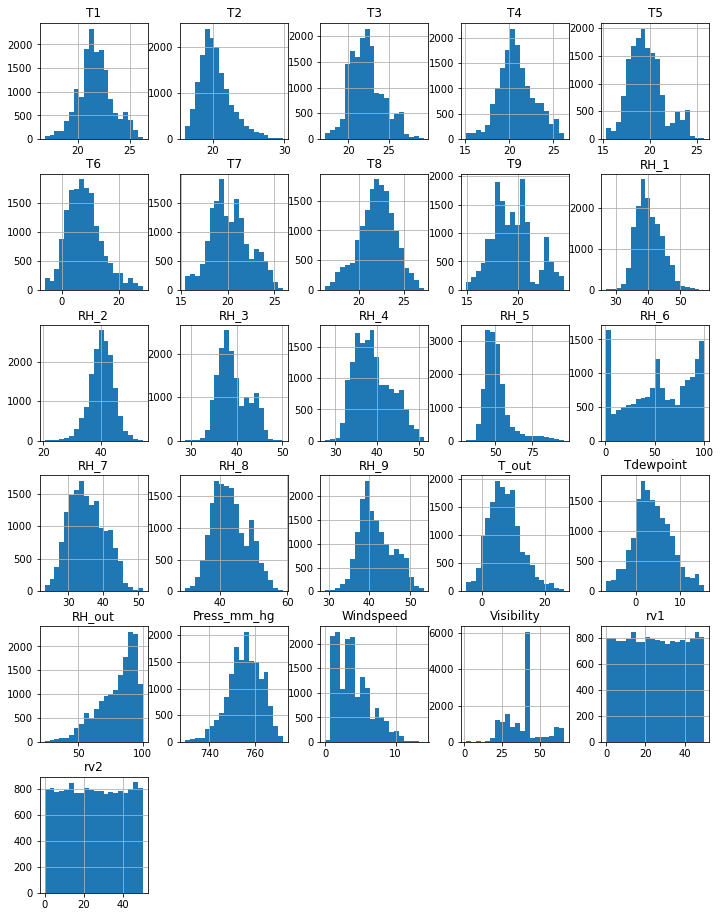

In [58]:
feature_vars.hist(bins = 20 , figsize= (12,16))

<AxesSubplot:xlabel='Appliance consumption in Wh', ylabel='Frequency'>

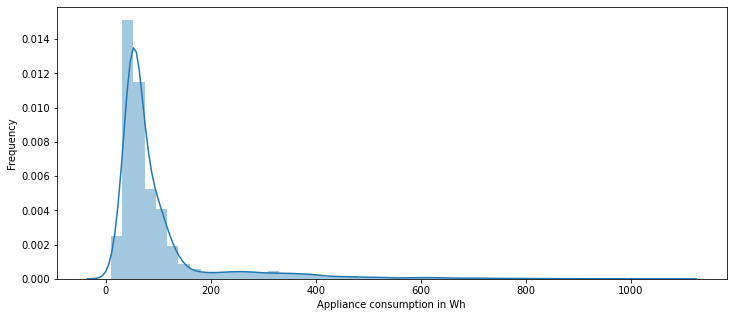

In [59]:
f = plt.figure(figsize=(12,5))
plt.xlabel('Appliance consumption in Wh')
plt.ylabel('Frequency')
sns.distplot(target_vars , bins=50 )

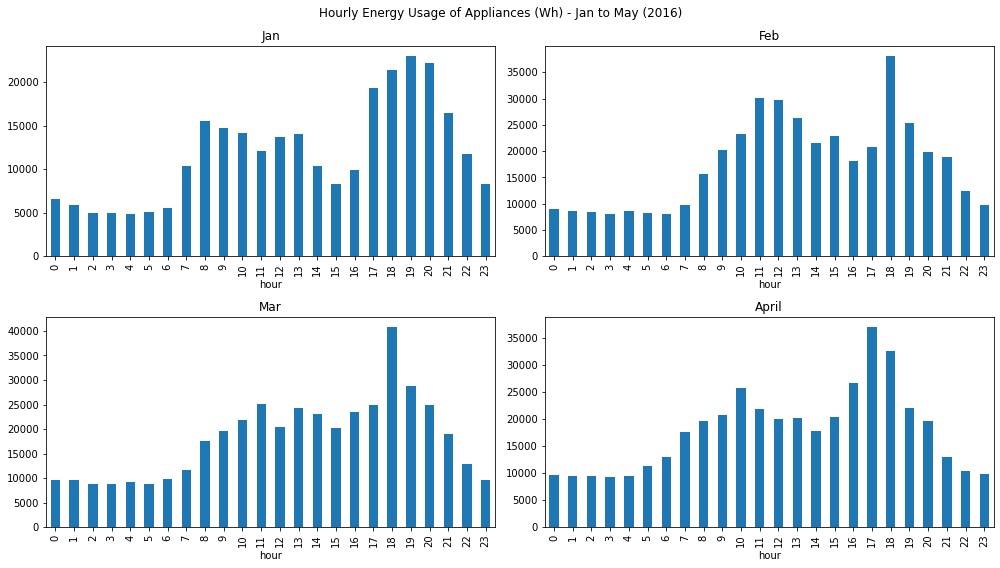

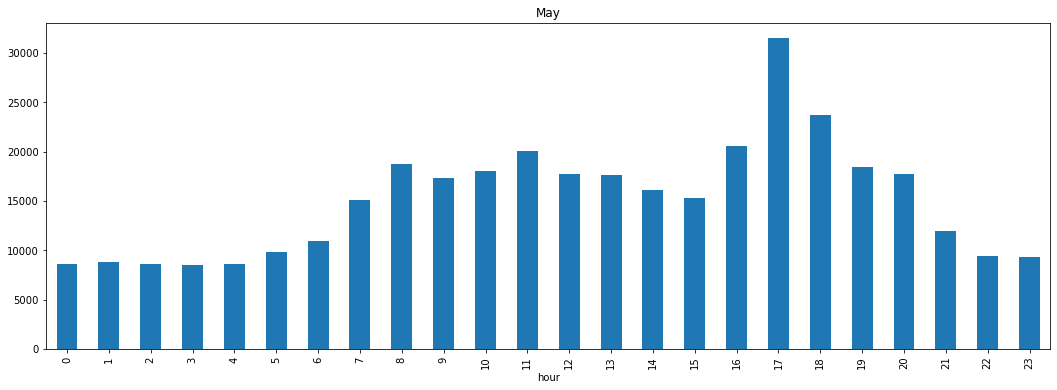

In [60]:
# Hourly energy usage
fig, ax = plt.subplots(2, 2, figsize=(14, 8))
ax = ax.flatten()

months = ['Jan', 'Feb', 'Mar', 'April']
for i in range(1, 5):
    df.query(f"month == {i}")[['hour', 'Appliances']].groupby('hour')['Appliances'].sum().plot.bar(ax=ax[i-1], title=months[i-1])
    
plt.suptitle('Hourly Energy Usage of Appliances (Wh) - Jan to May (2016)')
plt.tight_layout()
plt.show()

# Plotting May month's usage
plt.figure(figsize=(18, 6))
df.query("month == 5")[['hour', 'Appliances']].groupby('hour')['Appliances'].sum().plot.bar(title='May')
plt.show()

**Insights**
- Peak hours for maximum energy usage between 7-14 and 17-22 daily
- Lowest energy usage during night hours (0-6)

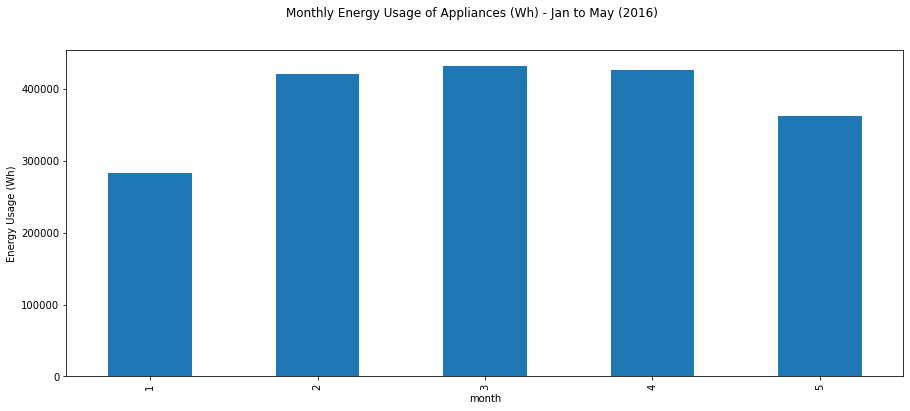

In [61]:
# Monthly energy usage
plt.figure(figsize=(15, 6))
df.groupby('month')['Appliances'].sum().plot.bar()
plt.suptitle('Monthly Energy Usage of Appliances (Wh) - Jan to May (2016)')
plt.ylabel('Energy Usage (Wh)')
plt.show()

In [62]:
def ts_plot(df: pd.DataFrame, cols: list, nrows: int, ncols: int, labels: list, title: str) -> None:
    """General function to plot temperature and humidity
    
    Args:
        df (pd.DataFrame): Dataframe
        cols (list): List of columns to plot
        nrows (int): Number of rows for subplot
        ncols (int): Number of columns for subplot
        labels (list): Labels of the plot
        title (str): Title of the plot
    """
    # sns.set(rc={"axes.facecolor":"#283747", "axes.grid":False,'xtick.labelsize':10,'ytick.labelsize':10})
    fig, ax = plt.subplots(nrows, ncols, figsize=(15, 8))
    ax = ax.flatten()

    for i, icol in enumerate(cols):
        sns.lineplot(data=df[icol], ax=ax[i], label=labels[i], color = '#4586ff')
        #ax[i].axhline(mean_temp, color='r', linestyle='--')

    plt.suptitle(title)
    plt.tight_layout()
    # leg = plt.legend() # Legend formatting
    # for text in leg.get_texts():
    #     text.set_color("white")
    plt.show()

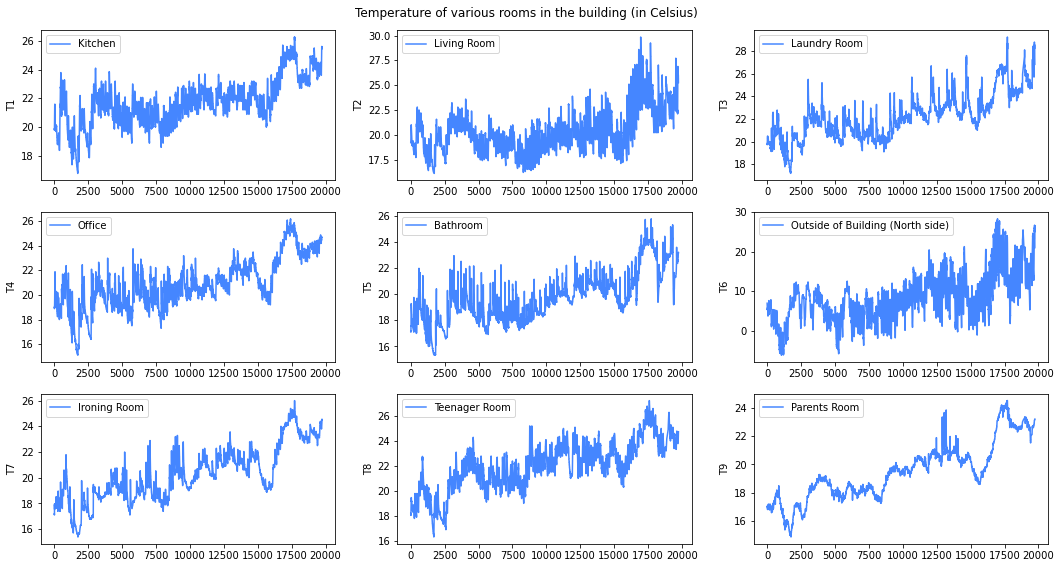

In [63]:
labels = ['Kitchen', 'Living Room', 'Laundry Room', 'Office', 'Bathroom', 
              'Outside of Building (North side)', 'Ironing Room', 'Teenager Room', 
              'Parents Room']
# Plot temperature features
temp_cols = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9']

ts_plot(df, temp_cols, 3, 3, labels, title='Temperature of various rooms in the building (in Celsius)')

**Insights**

- All the temperature readings have upward trends from Jan to May (Winter to Summer -- Temperature increases - 2016)

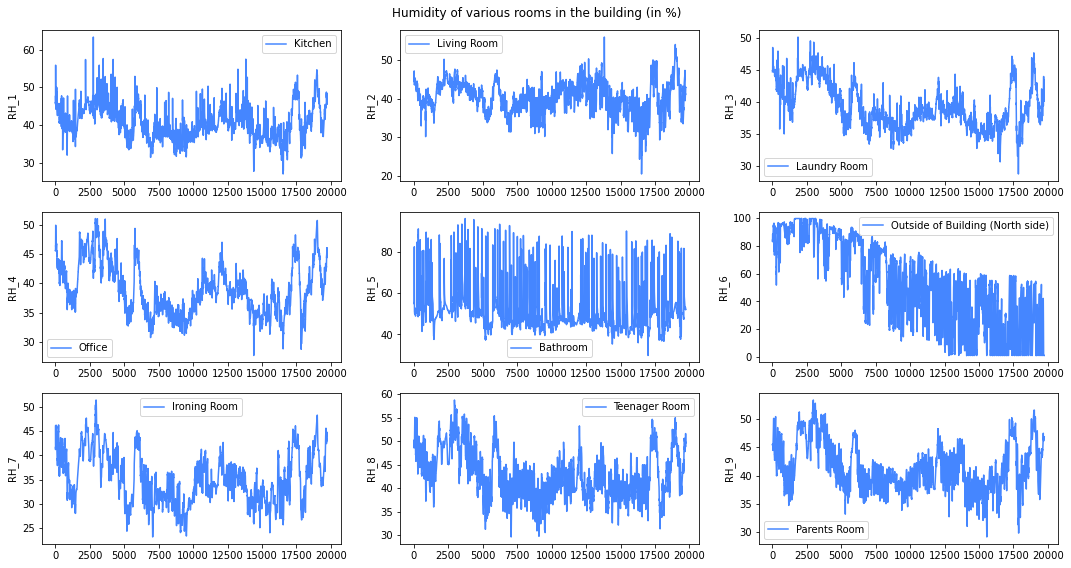

In [64]:
# Plot humidity features
humd_cols = ['RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9']

ts_plot(df, humd_cols, 3, 3, labels, title='Humidity of various rooms in the building (in %)')

**Insights**

- Humidity outside the bulding is decreasing over the time (from Jan to May) 
- Humidity measurements inside the building is more or less constant 

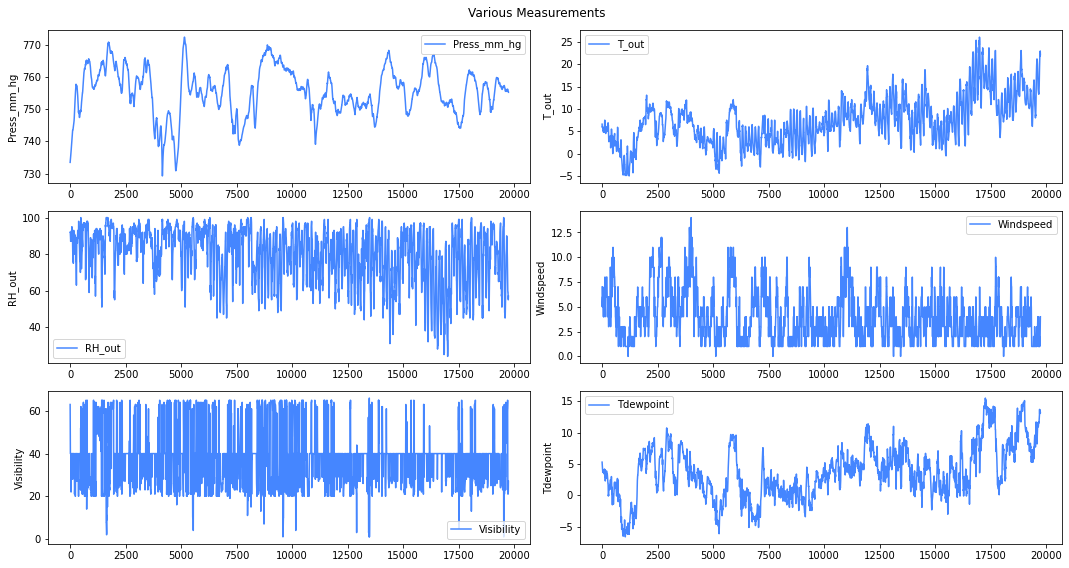

In [65]:
# Plot features other than temperature and humidity
cols = ['Press_mm_hg', 'T_out', 'RH_out', 'Windspeed', 'Visibility', 'Tdewpoint']

ts_plot(df, cols, 3, 2, cols, title='Various Measurements')

<AxesSubplot:>

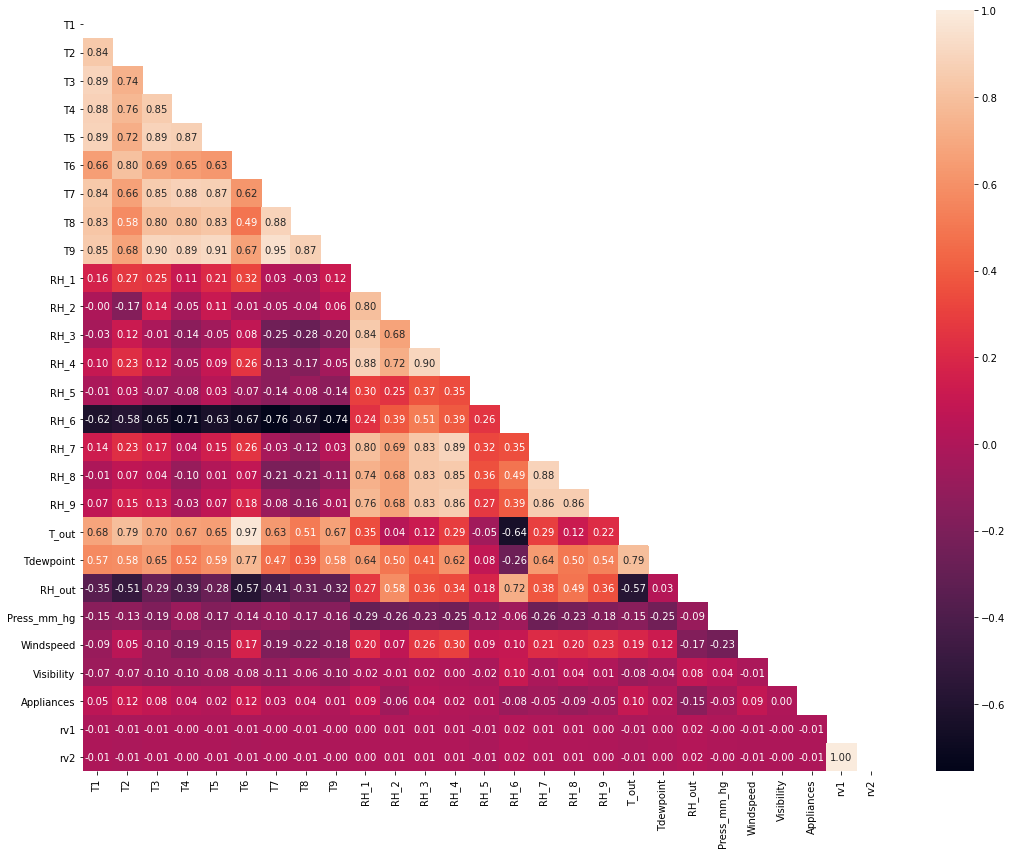

In [66]:
# Use the weather , temperature , applainces and random column to see the correlation
train_corr = train[col_temp + col_hum + col_weather +col_target+col_randoms]
corr = train_corr.corr()
# Mask the repeated values
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(18, 14))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, annot=True, fmt=".2f" , mask=mask)

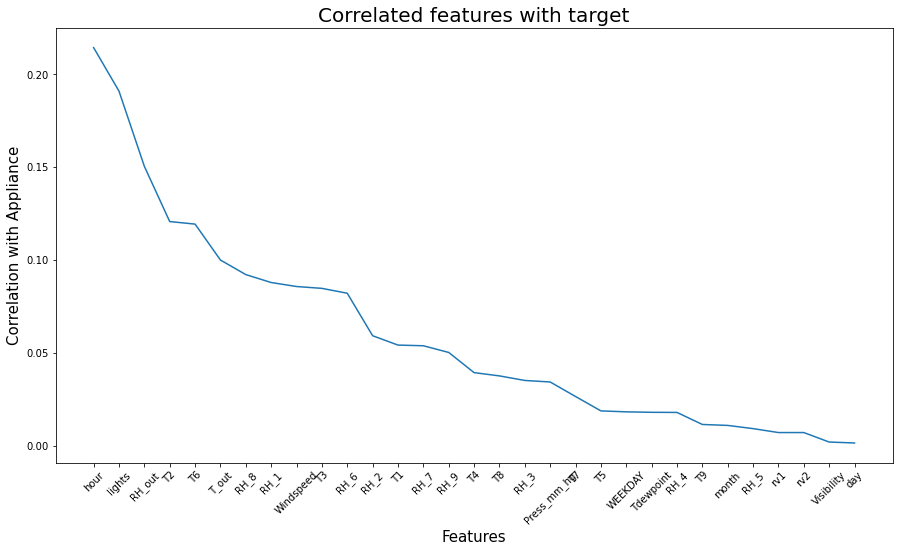

In [67]:
# Most correlated features

temp_df = train.drop('Appliances', axis=1)
corr_df = pd.DataFrame({'cols': temp_df.columns[1:]})
corr_df['val'] = 0

for i, icol in enumerate(corr_df['cols'].values):
    corr_df.iloc[i, 1] = abs(train['Appliances'].corr(temp_df[icol]))  # Accounting absolute correlation

corr_df = corr_df.sort_values(by=['val'], ascending=False).dropna()

plt.figure(figsize=(15, 8))
plt.plot(corr_df.cols, corr_df.val)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation with Appliance', fontsize=15)
plt.title('Correlated features with target', fontsize=20)
plt.xticks(rotation=45)
plt.show()

In [68]:
df_temp = df.copy()
df_temp['Appliances'] = df['Appliances']

crr_mat = df_temp.corr()
crr_mat['Appliances'].sort_values(ascending=False)

Appliances     1.000000
hour           0.216792
lights         0.197278
T2             0.120073
T6             0.117638
T_out          0.099155
Windspeed      0.087122
RH_1           0.086031
T3             0.085060
T1             0.055447
T4             0.040281
T8             0.039572
RH_3           0.036292
T7             0.025801
T5             0.019760
WEEKDAY        0.017437
RH_4           0.016965
Tdewpoint      0.015353
T9             0.010010
RH_5           0.006955
day            0.002366
Visibility     0.000230
rv2           -0.011145
rv1           -0.011145
month         -0.011606
Press_mm_hg   -0.034885
RH_9          -0.051462
RH_7          -0.055642
RH_2          -0.060465
RH_6          -0.083178
RH_8          -0.094039
RH_out        -0.152282
Name: Appliances, dtype: float64

**Insights**

- Lights is highly correlated feature with Appliances
- Visibility is least correlated feature with Appliance

### Data Preprocessing

In [69]:
x_train = train[feature_vars.columns]
y_train = train[target_vars.columns]

x_test = test[feature_vars.columns]
y_test = test[target_vars.columns]

In [70]:
# Due to conlusion made above below columns are removed
x_train.drop(["rv1","rv2","Visibility","RH_5","T9"],axis=1 , inplace=True)
x_test.drop(["rv1","rv2","Visibility","RH_5","T9"],axis=1 , inplace=True)

In [71]:
print(f'Train data: {x_train.shape, y_train.shape}')
print(f'Test data: {x_test.shape, y_test.shape}')

Train data: ((15788, 21), (15788, 1))
Test data: ((3947, 21), (3947, 1))


In [72]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

# Create test and training set by including Appliances column

train = train[list(x_train.columns.values) + col_target ]

test = test[list(x_test.columns.values) + col_target ]

# Create dummy test and training set to hold scaled values

sc_train = pd.DataFrame(columns=train.columns , index=train.index)

sc_train[sc_train.columns] = sc.fit_transform(train)

sc_test= pd.DataFrame(columns=test.columns , index=test.index)

sc_test[sc_test.columns] = sc.transform(test)

In [73]:
sc_train.head()

,T1,T2,T3,T4,T5,T6,T7,T8,RH_1,RH_2,...,RH_6,RH_7,RH_8,RH_9,T_out,Tdewpoint,RH_out,Press_mm_hg,Windspeed,Appliances
2133,-1.117535,-0.521432,-0.936016,-0.855218,-1.127855,0.522130,-1.307109,-2.000051,1.322565,1.145891,...,1.403280,1.583293,1.348111,1.715316,0.540910,0.992041,0.381152,0.863704,1.424184,-0.464931
19730,2.409418,2.524617,2.456153,1.875073,1.945969,2.766726,1.999713,1.363117,1.590438,0.392577,...,-1.718597,1.779016,1.362290,1.255750,2.874781,2.273160,-1.621760,-0.045041,-0.286316,0.019880
3288,0.504076,0.540967,-0.152313,0.558683,-0.269346,-0.226797,-0.461508,-0.746661,1.052165,0.531300,...,0.218719,-0.213443,-0.312946,0.952581,-0.153619,-0.852294,-1.062287,0.633127,1.629444,-0.271006
7730,-1.179665,-1.432060,-0.831411,-1.201379,-0.707005,-0.839705,-1.023668,-0.780690,-0.557603,0.124030,...,0.810519,-0.667520,-0.071728,-0.203953,-0.998318,-0.606383,0.974193,-1.898699,-1.244196,-0.561893
8852,-0.676407,-1.477591,-0.985827,-0.660197,-0.755634,-1.406180,0.204581,0.342257,-1.257611,-0.157043,...,0.445143,-0.356321,-0.709794,-0.356340,-1.555193,-1.359982,0.839920,1.727238,-0.970516,-0.561893


In [74]:
lr = LinearRegression() # Ridge()
lr.fit(x_train, y_train)

# #To retrieve the intercept:
# print(lr.intercept_)
# #For retrieving the slope:
# print(lr.coef_)
y_pred = lr.predict(x_test)
print(y_test.shape, y_pred.shape)

print(f'Training R2 score (LR): {r2_score(y_train, lr.predict(x_train))}')
print(f'Validation R2 Score (LR): {r2_score(y_test, y_pred)}')

(3947, 1) (3947, 1)
Training R2 score (LR): 0.13809460780197136
Validation R2 Score (LR): 0.13722052870221457
